In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data, load_football_data, create_weighted_scoreline_data
from src.model import build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Premier_League']
season = '2025-2026'



In [2]:
# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'/Users/admin/dev/algobetting/infra/data/db/fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.0015, 
    goals_weight=0.25,
    xg_weight=0.5,
    psxg_weight=0.15,
    epv_weight=0.1

)

df.head(5)

,match_id,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,home_idx,away_idx
0,4813503,Tottenham,Fulham,0,0,0.157447,65,False,17,9
1,4813503,Tottenham,Fulham,0,1,0.129641,65,False,17,9
2,4813503,Tottenham,Fulham,0,2,0.055372,65,False,17,9
3,4813503,Tottenham,Fulham,0,3,0.018722,65,False,17,9
4,4813503,Tottenham,Fulham,0,4,0.007961,65,False,17,9


In [3]:
import pandas as pd

def calculate_weighted_league_stats(weighted_df):
    # 1. Group by Match ID first to get the expected goals FOR EACH GAME
    # This collapses the 100+ scorelines back into one 'Expected Outcome' per match
    match_expectations = weighted_df.groupby('match_id').apply(lambda x: pd.Series({
        'exp_home_goals': (x['home_goals'] * x['weight']).sum() / x['weight'].sum(),
        'exp_away_goals': (x['away_goals'] * x['weight']).sum() / x['weight'].sum(),
        'match_weight': x['weight'].sum() # This handles time decay (usually ~1.0 or less)
    })).reset_index()

    # 2. Calculate League Averages using the collapsed match data
    # We use match_weight to ensure older games count for less in the average
    total_w = match_expectations['match_weight'].sum()
    avg_home_goals = (match_expectations['exp_home_goals'] * match_expectations['match_weight']).sum() / total_w
    avg_away_goals = (match_expectations['exp_away_goals'] * match_expectations['match_weight']).sum() / total_w
    avg_total_goals = avg_home_goals + avg_away_goals

    print("="*40)
    print("CORRECTED WEIGHTED LEAGUE AVERAGES")
    print("="*40)
    print(f"Avg Home Goals:  {avg_home_goals:.3f}")
    print(f"Avg Away Goals:  {avg_away_goals:.3f}")
    print(f"Avg Total Goals: {avg_total_goals:.3f}")
    print("="*40)

    # 3. Individual Team Stats (using the same 'collapsed' match expectations)
    # Join the match expectations back to the original match metadata to get team names
    match_meta = weighted_df[['match_id', 'home_team', 'away_team']].drop_duplicates()
    match_expectations = match_expectations.merge(match_meta, on='match_id')

    home_stats = match_expectations.groupby('home_team').apply(lambda x: pd.Series({
        'gf': (x['exp_home_goals'] * x['match_weight']).sum(),
        'ga': (x['exp_away_goals'] * x['match_weight']).sum(),
        'w': x['match_weight'].sum()
    }))

    away_stats = match_expectations.groupby('away_team').apply(lambda x: pd.Series({
        'gf': (x['exp_away_goals'] * x['match_weight']).sum(),
        'ga': (x['exp_home_goals'] * x['match_weight']).sum(),
        'w': x['match_weight'].sum()
    }))

    # Final Team Table
    team_stats = pd.DataFrame(index=home_stats.index)
    team_stats['gf_avg'] = (home_stats['gf'] + away_stats['gf']) / (home_stats['w'] + away_stats['w'])
    team_stats['ga_avg'] = (home_stats['ga'] + away_stats['ga']) / (home_stats['w'] + away_stats['w'])
    team_stats['net_rating'] = team_stats['gf_avg'] - team_stats['ga_avg']

    return team_stats.sort_values('net_rating', ascending=False)

# Execute
team_ratings = calculate_weighted_league_stats(df)
print(team_ratings)

CORRECTED WEIGHTED LEAGUE AVERAGES
Avg Home Goals:  1.380
Avg Away Goals:  1.127
Avg Total Goals: 2.507
                  gf_avg    ga_avg  net_rating
home_team                                     
Arsenal         1.662941  0.670149    0.992793
Man City        1.661618  1.036994    0.624624
Liverpool       1.496439  1.060178    0.436261
Man United      1.623622  1.265812    0.357809
Chelsea         1.608233  1.273885    0.334348
Newcastle       1.341541  1.113995    0.227546
Brentford       1.325974  1.135024    0.190950
Brighton        1.320584  1.171282    0.149302
Aston Villa     1.334600  1.205766    0.128834
Bournemouth     1.412547  1.429846   -0.017299
Crystal Palace  1.187135  1.216514   -0.029379
Leeds           1.246353  1.354327   -0.107973
Tottenham       1.193775  1.335995   -0.142220
Fulham          1.162414  1.317172   -0.154757
Everton         1.027242  1.230659   -0.203418
Nottm Forest    0.982949  1.252814   -0.269865
Sunderland      0.892093  1.209514   -0.317420
Wes

/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_49280/1378176539.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_expectations = weighted_df.groupby('match_id').apply(lambda x: pd.Series({
/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_49280/1378176539.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  home_stats = match_expectations.groupby('home_team').apply(lambda x: pd.Series({
/

In [4]:
import pandas as pd

# 1. Create two small dataframes for Home and Away occurrences
home_matches = df[['match_id', 'home_team']].rename(columns={'home_team': 'team'})
away_matches = df[['match_id', 'away_team']].rename(columns={'away_team': 'team'})

# 2. Stack them on top of each other
all_match_appearances = pd.concat([home_matches, away_matches])

# 3. Group by team and count unique Match IDs
match_counts = all_match_appearances.groupby('team')['match_id'].nunique().reset_index()

# 4. Rename for clarity
match_counts.columns = ['Team', 'Matches_Played']

print(match_counts.sort_values(by='Matches_Played', ascending=False))


              Team  Matches_Played
0          Arsenal              24
1      Aston Villa              24
18        West Ham              24
17       Tottenham              24
16      Sunderland              24
15    Nottm Forest              24
14       Newcastle              24
13      Man United              24
12        Man City              24
11       Liverpool              24
10           Leeds              24
9           Fulham              24
8          Everton              24
7   Crystal Palace              24
6          Chelsea              24
5          Burnley              24
4         Brighton              24
3        Brentford              24
2      Bournemouth              24
19          Wolves              24


In [5]:
df[df["match_id"] == 4813374]["weight"].sum()

np.float64(0.7737549945594723)

In [6]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 1),
    'Aston Villa': (0.121, 1),
    'Bournemouth': (0.100, 1),
    'Brentford': (0.079, 1),
    'Brighton': (0.083, 1),
    'Chelsea': (0.185, 1),
    'Crystal Palace': (0.057, 1),
    'Everton': (-0.108, 1),
    'Fulham': (-0.030, 1),
    'Liverpool': (0.571, 1),
    'Man City': (0.297, 1),
    'Man United': (0.011, 1),
    'Newcastle': (0.207, 1),
    'Nottm Forest': (-0.003, 1),
    'Tottenham': (0.121, 1),
    'West Ham': (-0.082, 1),
    'Wolves': (-0.094, 1),

    'Burnley': (-0.401, 1),
    'Leeds': (-0.103, 1),
    'Sunderland': (-0.553, 1)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 1),
    'Aston Villa': (-0.085, 1),
    'Bournemouth': (-0.001, 1),
    'Brentford': (-0.054, 1),
    'Brighton': (0.107, 1),
    'Chelsea': (-0.166, 1),
    'Crystal Palace': (0.052, 1),
    'Everton': (-0.085, 1),
    'Fulham': (-0.014, 1),
    'Liverpool': (-0.222, 1),
    'Man City': (-0.191, 1),
    'Man United': (-0.035, 1),
    'Newcastle': (-0.083, 1),
    'Nottm Forest': (-0.046, 1),
    'Tottenham': (0.163, 1),
    'West Ham': (0.103, 1),
    'Wolves': (0.137, 1),

    'Burnley': (0.163, 1),
    'Leeds': (0.163, 1),
    'Sunderland': (0.231, 1)
}



In [7]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=20000,
     tune=10000,
     manual_att_priors=manual_att_priors,
     manual_def_priors=manual_def_priors
 )

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.304  0.274  -0.189    0.831      0.013    0.006     413.0     768.0   1.00
att_str_raw[1]   0.126  0.293  -0.422    0.685      0.013    0.007     495.0     930.0   1.00
att_str_raw[2]   0.164  0.285  -0.347    0.720      0.013    0.007     470.0     906.0   1.01
att_str_raw[3]   0.089  0.293  -0.466    0.638      0.013    0.007     477.0     849.0   1.00
att_str_raw[4]   0.074  0.293  -0.476    0.626      0.014    0.007     445.0     832.0   1.00
att_str_raw[5]  -0.377  0.312  -0.992    0.185      0.013    0.006     584.0    1127.0   1.00
att_str_raw[6]   0.275  0.279  -0.243    0.789      0.013    0.008     446.0     764.0   1.00
att_str_raw[7]  -0.011  0.288  -0.542    0.524      0.013    0.007     533.0    1010.0   1.00
att_str_raw[8]  -0.154  0.298  -0.696    0.397      0.014    0.006     473.0     964.0   1.00
att_str_raw[9]  -0.032  0.294  -0.599    0.509      0.013   

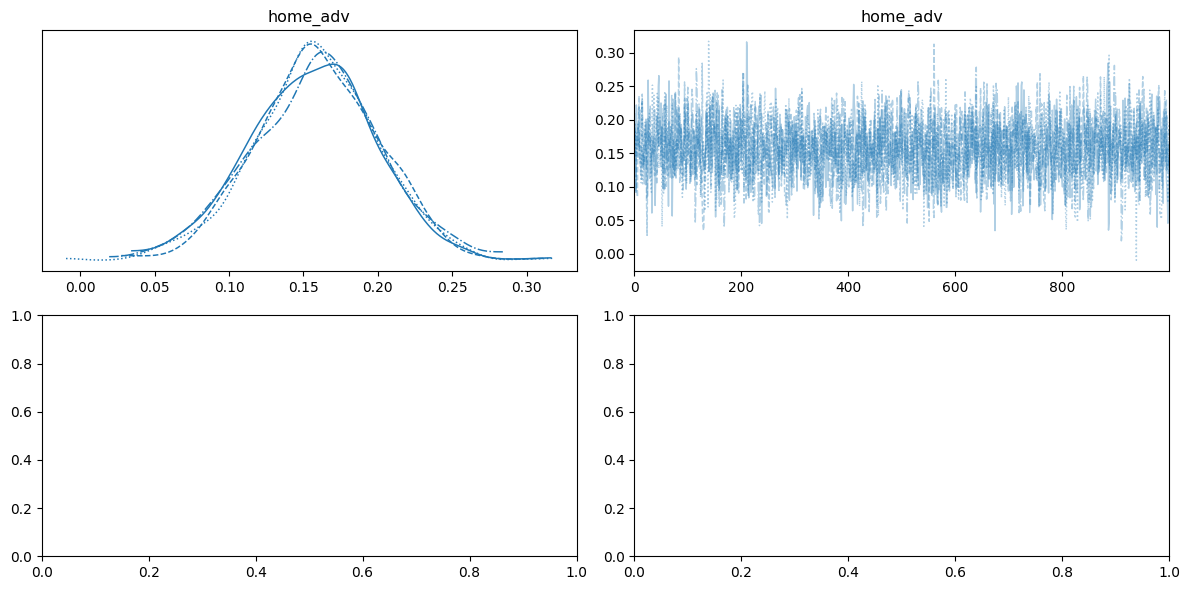

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['home_adv'], axes=axes)
plt.tight_layout()
plt.show()


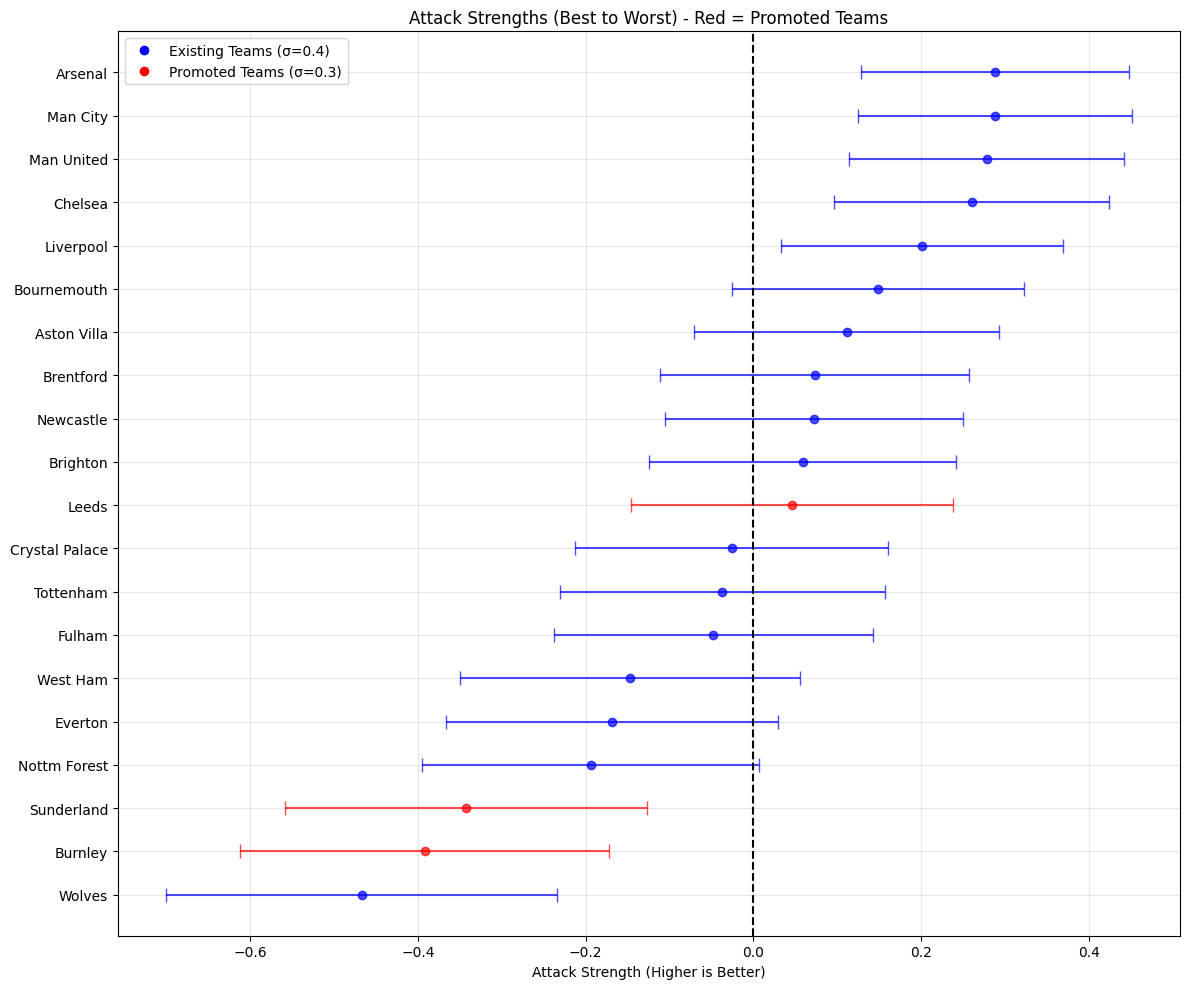

In [9]:
# Extract attack data
att_means = []
att_stds = []
att_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    att_means.append(summary.loc[f'att_str[{i}]', 'mean'])
    att_stds.append(summary.loc[f'att_str[{i}]', 'sd'])
    att_team_names.append(team_name)

# Create DataFrame and sort by attack strength (higher is better attack)
att_data = list(zip(att_means, att_stds, att_team_names))
att_data_sorted = sorted(att_data, key=lambda x: x[0], reverse=True)  # Sort by mean (descending)

# Extract sorted data
sorted_att_means = [x[0] for x in att_data_sorted]
sorted_att_stds = [x[1] for x in att_data_sorted]
sorted_att_names = [x[2] for x in att_data_sorted]

# Create attack plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_att_means, sorted_att_stds, sorted_att_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Flip the y-position so best is at top
    ax.errorbar(mean, len(sorted_att_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_att_names)))
ax.set_yticklabels(reversed(sorted_att_names))  # Reverse the labels to match
ax.set_xlabel('Attack Strength (Higher is Better)')
ax.set_title('Attack Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=1)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.4)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

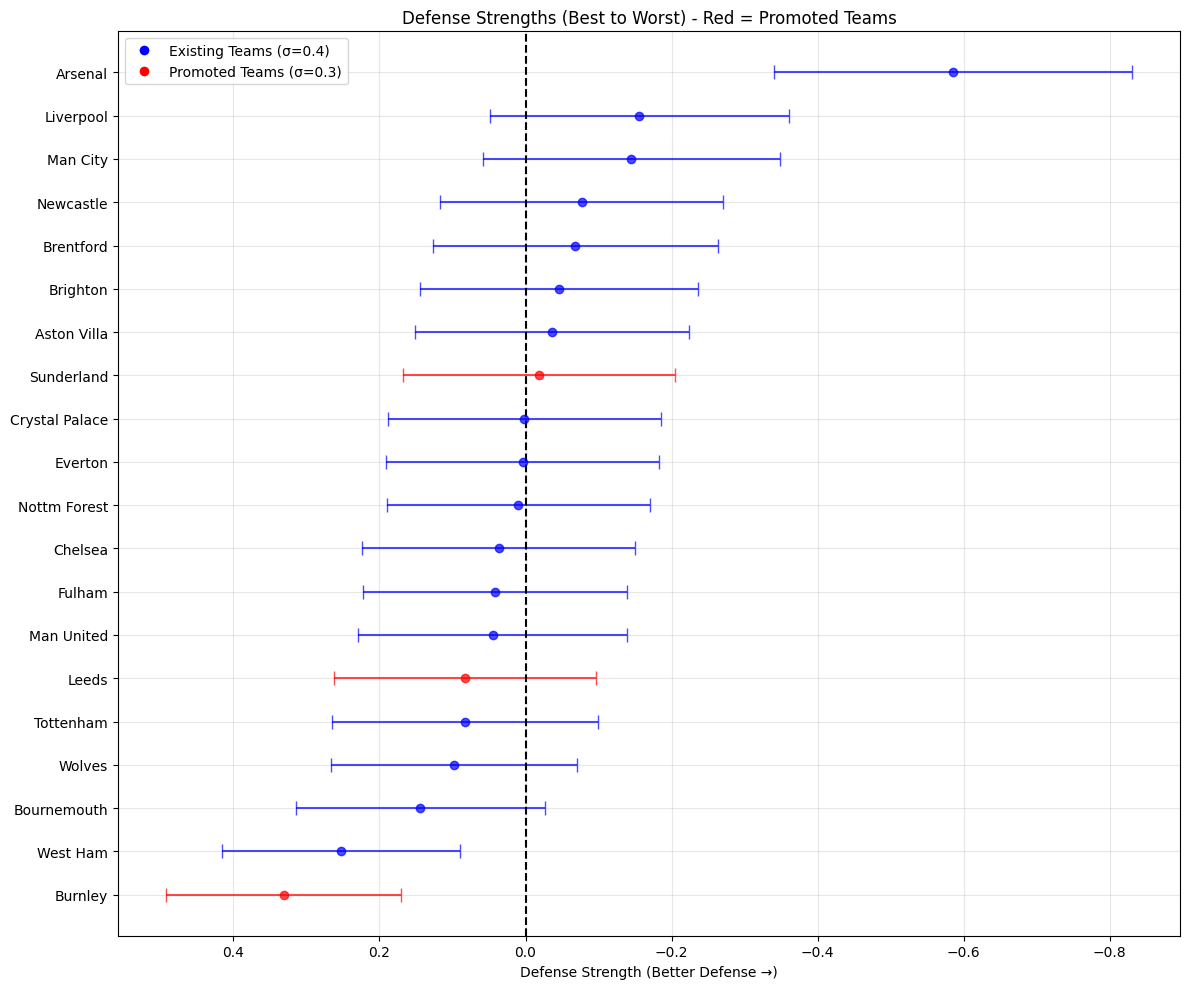

In [10]:
# Extract defense data
def_means = []
def_stds = []
def_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    def_means.append(summary.loc[f'def_str[{i}]', 'mean'])
    def_stds.append(summary.loc[f'def_str[{i}]', 'sd'])
    def_team_names.append(team_name)

# Create DataFrame and sort by defense strength (lower is better defense)
def_data = list(zip(def_means, def_stds, def_team_names))
def_data_sorted = sorted(def_data, key=lambda x: x[0])  # Sort by mean (ascending)

# Extract sorted data
sorted_def_means = [x[0] for x in def_data_sorted]
sorted_def_stds = [x[1] for x in def_data_sorted]
sorted_def_names = [x[2] for x in def_data_sorted]

# Create defense plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_def_names))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_def_means, sorted_def_stds, sorted_def_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Reverse y-position so best defense is at top
    ax.errorbar(mean, len(sorted_def_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_def_names)))
ax.set_yticklabels(reversed(sorted_def_names))  # Reverse labels to match reversed positions
ax.set_xlabel('Defense Strength (Better Defense →)')
ax.set_title('Defense Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=1)
ax.invert_xaxis()  # Flip x-axis so negative is to the right

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.4)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [11]:
# Establish pen predictions

# Penalty baselines (from analysis)
BASELINE_HOME_PENS = 0.157 * 0.78
BASELINE_AWAY_PENS = 0.101 * 0.78

In [12]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 ) + BASELINE_AWAY_PENS # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength) + BASELINE_AWAY_PENS # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df['goals_for'].sum():.2f}')
print(f'Total Goals Against: {ratings_df['goals_against'].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.096
Home advantage: 0.158

Total Goals For: 24.12
Total Goals Against: 23.91

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.55           0.69              0.85
      Man City       1.55           1.03              0.52
     Liverpool       1.42           1.02              0.40
    Man United       1.53           1.23              0.30
       Chelsea       1.51           1.22              0.29
   Aston Villa       1.31           1.14              0.17
     Newcastle       1.26           1.10              0.16
     Brentford       1.26           1.11              0.16
      Brighton       1.25           1.13              0.12
   Bournemouth       1.36           1.35              0.01
Crystal Palace       1.15           1.18             -0.03
         Leeds       1.23           1.27             -0.04
        Fulham       1.13       

In [13]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []
for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team AT HOME
    goals_for_home = np.exp(baseline_mean + home_adv_mean + att_strength + 0) + BASELINE_HOME_PENS # vs avg def (0)
    
    # Goals scored vs average team AWAY
    goals_for_away = np.exp(baseline_mean + att_strength + 0) + BASELINE_AWAY_PENS # vs avg def (0), no home adv
    
    # Average goals for
    goals_for = (goals_for_home + goals_for_away) / 2
    
    # Goals conceded vs average team AT HOME (defending)
    goals_against_home = np.exp(baseline_mean + 0 + def_strength)  # avg att (0), no home adv for opponent
    
    # Goals conceded vs average team AWAY (defending)
    goals_against_away = np.exp(baseline_mean + home_adv_mean + 0 + def_strength)  # avg att (0) with opponent's home adv
    
    # Average goals against
    goals_against = (goals_against_home + goals_against_away) / 2
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df["goals_for"].sum():.2f}')
print(f'Total Goals Against: {ratings_df["goals_against"].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()
pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.096
Home advantage: 0.158

Total Goals For: 26.48
Total Goals Against: 24.25

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.69           0.67              1.03
      Man City       1.69           1.03              0.66
     Liverpool       1.56           1.02              0.54
    Man United       1.68           1.25              0.43
       Chelsea       1.65           1.24              0.41
   Aston Villa       1.44           1.15              0.28
     Newcastle       1.38           1.11              0.28
     Brentford       1.39           1.12              0.27
      Brighton       1.37           1.14              0.23
   Bournemouth       1.49           1.38              0.11
Crystal Palace       1.26           1.20              0.07
         Leeds       1.35           1.30              0.05
        Fulham       1.24       

In [14]:
import numpy as np
import pandas as pd

# 1. Pull the full posterior samples (chains * draws)
# This converts the distribution of each parameter into a flat array
baseline_samples = trace.posterior['baseline'].values.flatten()
home_adv_samples = trace.posterior['home_adv'].values.flatten()

all_teams = list(team_mapping.keys())
total_goals_all_matchups = 0
matchup_count = 0

team_stats = {team: {'goals_for': 0, 'goals_against': 0, 'matches': 0} for team in all_teams}

for home_team in all_teams:
    home_idx = team_mapping[home_team]
    
    # Get all samples for home team's attack/defense
    home_att_samples = trace.posterior['att_str'].sel(att_str_dim_0=home_idx).values.flatten()
    home_def_samples = trace.posterior['def_str'].sel(def_str_dim_0=home_idx).values.flatten()
    
    for away_team in all_teams:
        if home_team == away_team:
            continue
            
        away_idx = team_mapping[away_team]
        away_att_samples = trace.posterior['att_str'].sel(att_str_dim_0=away_idx).values.flatten()
        away_def_samples = trace.posterior['def_str'].sel(def_str_dim_0=away_idx).values.flatten()
        
        # --- THE BAYESIAN FIX ---
        # Calculate goals for EVERY sample in the trace (e.g., 20,000 values)
        # Jensen's Inequality: Mean(exp(x)) > exp(Mean(x))
        home_lambda_samples = np.exp(
            baseline_samples + home_adv_samples + home_att_samples + away_def_samples
        )
        away_lambda_samples = np.exp(
            baseline_samples + away_att_samples + home_def_samples
        )
        
        # Take the mean of the resulting goals to get the true expectation
        home_goals = np.mean(home_lambda_samples) + BASELINE_HOME_PENS
        away_goals = np.mean(away_lambda_samples) + BASELINE_AWAY_PENS
        
        # Track totals
        total_goals_all_matchups += (home_goals + away_goals)
        matchup_count += 1
        
        # Track per-team stats
        team_stats[home_team]['goals_for'] += home_goals
        team_stats[home_team]['goals_against'] += away_goals
        team_stats[home_team]['matches'] += 1
        
        team_stats[away_team]['goals_for'] += away_goals
        team_stats[away_team]['goals_against'] += home_goals
        team_stats[away_team]['matches'] += 1

# ... [The rest of your averaging and printing logic remains exactly the same] ...

# Calculate averages per team
team_ratings = []
for team in all_teams:
    avg_goals_for = team_stats[team]['goals_for'] / team_stats[team]['matches']
    avg_goals_against = team_stats[team]['goals_against'] / team_stats[team]['matches']
    goal_diff = avg_goals_for - avg_goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': avg_goals_for,
        'goals_against': avg_goals_against,
        'goal_diff': goal_diff
    })

# Convert to DataFrame and sort
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff', ascending=False)

# Display results
avg_goals_per_match = total_goals_all_matchups / matchup_count

print("=" * 80)
print("AVERAGE GOALS ACROSS ALL POSSIBLE MATCHUPS")
print("=" * 80)
print(f"Average goals per match: {avg_goals_per_match:.2f}")
print(f"Total matchups analyzed: {matchup_count}")
print()

print("=" * 80)
print("TEAM RATINGS (sorted by goal difference)")
print("=" * 80)
pd.set_option('display.float_format', '{:.2f}'.format)
print(ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff']].to_string(index=False))

print()
print("=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total goals for (sum): {ratings_df['goals_for'].sum():.2f}")
print(f"Total goals against (sum): {ratings_df['goals_against'].sum():.2f}")
print(f"Average goals for per team: {ratings_df['goals_for'].mean():.2f}")
print(f"Average goals against per team: {ratings_df['goals_against'].mean():.2f}")

AVERAGE GOALS ACROSS ALL POSSIBLE MATCHUPS
Average goals per match: 2.77
Total matchups analyzed: 380

TEAM RATINGS (sorted by goal difference)
          team  goals_for  goals_against  goal_diff
       Arsenal       1.81           0.80       1.00
      Man City       1.78           1.18       0.60
     Liverpool       1.64           1.18       0.46
    Man United       1.75           1.41       0.34
       Chelsea       1.72           1.40       0.32
   Aston Villa       1.51           1.32       0.19
     Newcastle       1.45           1.27       0.18
     Brentford       1.46           1.28       0.17
      Brighton       1.44           1.31       0.13
   Bournemouth       1.54           1.55      -0.01
Crystal Palace       1.32           1.37      -0.05
         Leeds       1.41           1.47      -0.06
        Fulham       1.30           1.43      -0.13
     Tottenham       1.31           1.48      -0.17
       Everton       1.16           1.38      -0.22
  Nottm Forest       1.1

In [15]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025.9,  # Replace with your actual season year
    league="Premier_League",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025.9
Trace saved to: model_traces/manual_priors/trace_Premier_League_2025.9.nc


In [16]:
import numpy as np
import pandas as pd
import random

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # 1. Calculate the "Open Play" rate from the model
    home_open_play_lambda = np.exp(baseline + home_adv + att_str[:, home_idx] + def_str[:, away_idx])
    away_open_play_lambda = np.exp(baseline + att_str[:, away_idx] + def_str[:, home_idx])
    
    # 2. Add the Penalty Baseline to get the Total Rate
    home_total_lambda = home_open_play_lambda + BASELINE_HOME_PENS
    away_total_lambda = away_open_play_lambda + BASELINE_AWAY_PENS
    
    # 3. Predict actual goals
    home_goals_pred = np.random.poisson(home_total_lambda)
    away_goals_pred = np.random.poisson(away_total_lambda)

    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_total_lambda),
        'away_goals_expected': np.mean(away_total_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

matches = [
    ('Arsenal', 'Sunderland'),
    ('Bournemouth', 'Aston Villa'),
    ('Brighton', 'Crystal Palace'),
    ('Burnley', 'West Ham'),
    ('Fulham', 'Everton'),
    ('Leeds', 'Nottm Forest'),
    ('Liverpool', 'Man City'),
    ('Man United', 'Tottenham'),
    ('Newcastle', 'Brentford'),
    ('Wolves', 'Chelsea')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Arsenal         vs Sunderland     : 1.86-0.54 (69%-21%-10%) Total: 2.4
Bournemouth     vs Aston Villa    : 1.61-1.54 (41%-22%-37%) Total: 3.2
Brighton        vs Crystal Palace : 1.54-1.14 (45%-25%-30%) Total: 2.7
Burnley         vs West Ham       : 1.29-1.45 (33%-26%-41%) Total: 2.7
Fulham          vs Everton        : 1.40-1.09 (45%-25%-30%) Total: 2.5
Leeds           vs Nottm Forest   : 1.54-1.10 (47%-25%-28%) Total: 2.6
Liverpool       vs Man City       : 1.54-1.38 (41%-24%-34%) Total: 2.9
Man United      vs Tottenham      : 2.03-1.23 (54%-22%-24%) Total: 3.3
Newcastle       vs Brentford      : 1.47-1.22 (43%-25%-32%) Total: 2.7
Wolves          vs Chelsea        : 1.00-1.70 (23%-23%-53%) Total: 2.7
TOTAL GOALS ACROSS ALL MATCHES: 27.66
AVERAGE GOALS PER MATCH: 2.77


In [17]:
def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1  # Start position from 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

def simulate_full_season(trace, team_mapping, df_actual):
    """Simulate a full season using actual results where available and simulating unplayed matches"""
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,
        'xg_against': 0.0,
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Create a set of played matches for quick lookup
    # Assuming df_actual has columns: home_team, away_team, is_actual
    played_matches = set()
    if df_actual is not None and 'is_actual' in df_actual.columns:
        actual_games = df_actual[df_actual['is_actual'] == True]
        for _, row in actual_games.iterrows():
            played_matches.add((row['home_team'], row['away_team']))
    
    # Generate all possible matches
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                
                # Check if this match has already been played
                if (home_team, away_team) in played_matches:
                    # Use actual result
                    actual_match = df_actual[
                        (df_actual['home_team'] == home_team) & 
                        (df_actual['away_team'] == away_team) & 
                        (df_actual['is_actual'] == True)
                    ].iloc[0]
                    
                    home_goals = int(actual_match['home_goals'])
                    away_goals = int(actual_match['away_goals'])
                    
                    # Get xG if available in the dataframe, otherwise predict
                    if 'home_xg' in actual_match and 'away_xg' in actual_match:
                        home_xg = actual_match['home_xg']
                        away_xg = actual_match['away_xg']
                    else:
                        result = predict_match(home_team, away_team, trace, team_mapping)
                        home_xg = result['home_goals_expected']
                        away_xg = result['away_goals_expected']
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': home_xg,
                        'away_expected': away_xg,
                        'is_actual': True
                    }
                else:
                    # Simulate the match
                    result = predict_match(home_team, away_team, trace, team_mapping)
                    
                    home_goals = np.random.poisson(result['home_goals_expected'])
                    away_goals = np.random.poisson(result['away_goals_expected'])
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': result['home_goals_expected'],
                        'away_expected': result['away_goals_expected'],
                        'is_actual': False
                    }
                
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += match_result['home_expected']
                league_table[home_team]['xg_against'] += match_result['away_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += match_result['away_expected']
                league_table[away_team]['xg_against'] += match_result['home_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

# Usage:
print("Simulating full season with actual results...")
league_table, all_matches = simulate_full_season(trace, team_mapping, df)  # Pass your df here
final_table = print_league_table(league_table)

# Additional statistics showing actual vs simulated
actual_matches = sum(1 for match in all_matches if match.get('is_actual', False))
simulated_matches = len(all_matches) - actual_matches
total_goals = sum([match['home_goals'] + match['away_goals'] for match in all_matches])

print(f"\nSEASON STATISTICS:")
print(f"Actual matches: {actual_matches}")
print(f"Simulated matches: {simulated_matches}")
print(f"Total matches: {len(all_matches)}")
print(f"Total goals: {total_goals}")
print(f"Average goals per match: {total_goals/len(all_matches):.2f}")


Simulating full season with actual results...

PREDICTED FINAL LEAGUE TABLE (with Expected Goals)
Pos Team             P  W  D  L  GF  GA   GD   xGF   xGA   xGD Pts
--------------------------------------------------------------------------------------------------------------
  1 Man City        38 25  6  7  76  35  +41  67.7  45.0 +22.7  81
  2 Arsenal         38 21 11  6  66  29  +37  68.7  30.6 +38.1  74
  3 Aston Villa     38 22  5 11  61  47  +14  57.2  50.1  +7.1  71
  4 Liverpool       38 17 10 11  64  52  +12  62.4  44.8 +17.7  61
  5 Man United      38 16 12 10  70  58  +12  66.5  53.4 +13.1  60
  6 Chelsea         38 17  7 14  57  52   +5  65.4  53.1 +12.3  58
  7 Brentford       38 16 10 12  47  44   +3  55.3  48.8  +6.6  58
  8 Newcastle       38 16  8 14  54  46   +8  55.2  48.4  +6.9  56
  9 Bournemouth     38 15 11 12  60  55   +5  58.6  58.9  -0.2  56
 10 Brighton        38 15 11 12  50  45   +5  54.5  49.7  +4.8  56
 11 Fulham          38 16  7 15  52  53   -1  49.3  54

In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict

def run_multiple_seasons(n_simulations, trace, team_mapping, df_actual):
    """Run multiple season simulations using actual results and return averaged results"""
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics - now including xG
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0,
        'title_count': 0,
        'top5_count': 0,
        'relegation_count': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}  # 20 positions
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation with actual results
        league_table, _ = simulate_full_season(trace, team_mapping, df_actual)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1  # Position 1-20
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            # Track title, top 4, and relegation
            if final_position == 1:
                accumulated_stats[team]['title_count'] += 1
            if final_position <= 5:
                accumulated_stats[team]['top5_count'] += 1
            if final_position >= 18:
                accumulated_stats[team]['relegation_count'] += 1
            
            # Track position frequency
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': stats['total_xg_for'] / n_simulations,
            'avg_xg_against': stats['total_xg_against'] / n_simulations,
            'avg_position': stats['position_sum'] / n_simulations,
            'title_pct': (stats['title_count'] / n_simulations) * 100,
            'top5_pct': (stats['top5_count'] / n_simulations) * 100,
            'relegation_pct': (stats['relegation_count'] / n_simulations) * 100
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

# Run simulations with actual results
n_sims = 100
print(f"Using actual results and simulating remaining fixtures...")
avg_table, position_freq = run_multiple_seasons(n_sims, trace, team_mapping, df)

# Count actual matches to calculate correct games per season
actual_matches_per_team = df[df['is_actual'] == True].groupby('home_team').size().mean() + \
                           df[df['is_actual'] == True].groupby('away_team').size().mean()
games_per_season = 38  # Total games in a full season

# Print averaged league table with per-game stats
print("\n" + "="*170)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*170)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/G':>6} {'GA/G':>6} {'GD/G':>6} "
      f"{'xGF/G':>7} {'xGA/G':>7} {'xGD/G':>7} {'Avg Pos':>8} {'Title%':>7} {'Top5%':>6} {'Rel%':>5}")
print("-"*170)

for pos, row in avg_table.iterrows():
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f} "
          f"{row['title_pct']:7.1f} "
          f"{row['top5_pct']:6.1f} "
          f"{row['relegation_pct']:5.1f}")

Using actual results and simulating remaining fixtures...
Running 100 season simulations...

AVERAGE LEAGUE TABLE OVER 100 SIMULATIONS (Per Game Stats)
Pos Team              Pts     W     D     L   GF/G   GA/G   GD/G   xGF/G   xGA/G   xGD/G  Avg Pos  Title%  Top5%  Rel%
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1 Arsenal          80.2  23.7   9.0   5.2   1.80   0.73  +1.06    1.81    0.80   +1.00     1.14    86.0  100.0   0.0
  2 Man City         72.6  21.5   8.2   8.3   1.91   1.00  +0.91    1.78    1.18   +0.60     2.25    12.0   98.0   0.0
  3 Aston Villa      66.9  19.9   7.3  10.8   1.48   1.17  +0.32    1.51    1.32   +0.19     3.80     2.0   89.0   0.0
  4 Liverpool        64.3  18.0  10.3   9.7   1.60   1.24  +0.36    1.64    1.18   +0.46     4.47     0.0   79.0   0.0
  5 Man United       61.1  16.2  12.4   9.4   1.73   1.41  +0.33    1.75    1.41  

In [19]:
pretty_df = ''

In [20]:
from datawrapper import Datawrapper
import pandas as pd

dw = Datawrapper(access_token = "ZVnOtN7rfXBTiW0BCZMKlhsUayDXBMoCRM39KzRRLmSj3Q1Far3V1FaSC0yIyhbM")

# ---- Team Logos (replace/add all 20 teams) ----
team_logos = {
    "Arsenal": "https://rawcdn.githack.com/louis-porter/prem_logos/main/Arsenal.png",
    # add other teams similarly
}

# ---- Team Colors ----
team_colors = {
    "Arsenal": "#EF0107",
    # add all teams...
}

# ---- Prepare DataFrame ----
pretty_df = avg_table.rename(columns={
    'team': 'Team',
    'avg_points': 'Points',
    'avg_wins': 'Wins',
    'avg_draws': 'Draws',
    'avg_losses': 'Losses',
    'avg_goals_for': 'Goals For',
    'avg_goals_against': 'Goals Against',
    'avg_goal_difference': 'Goal Diff',
})
pretty_df = pretty_df[
    ['Team', 'Points', 'Wins', 'Draws', 'Losses',
     'Goals For', 'Goals Against', 'Goal Diff']
]
pretty_df = pretty_df.round(2)
pretty_df = pretty_df[pretty_df["Team"] == 'Arsenal']

# ---- Add Logo Column with just the URL (no HTML) ----
pretty_df["Logo"] = pretty_df["Team"].map(team_logos)

# ---- Move logo column to the first position ----
pretty_df = pretty_df[
    ["Logo"] + [col for col in pretty_df.columns if col != "Logo"]
]

# ---- Create Table ----
chart = dw.create_chart(
    title="Average Premier League Table (Simulations)",
    chart_type="tables"
)

# Upload table data
dw.add_data(chart["id"], pretty_df)

# Update metadata with proper column format
metadata = {
    "data": {
        "column-format": {
            "Logo": {
                "type": "image",
                "height": 20
            }
        }
    },
    "visualize": {
        "table": {
            "show-header": True,
            "compact": True,
            "freeze-header": True,
            "allow-html": True,
            "vertical-padding": 2,
            "horizontal-padding": 4,
            "font-size": "12px",
            "striped": True,
            "line-height": 1.1
        }
    }
}

dw.update_metadata(chart["id"], metadata)

# Publish
dw.publish_chart(chart["id"])
print("Chart ID:", chart["id"])
print("Chart URL: https://app.datawrapper.de/chart/" + chart["id"])

/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_49280/879953049.py:45: DeprecationWarning: create_chart() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart(title='My Chart', data=df).create()
  chart = dw.create_chart(
/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_49280/879953049.py:51: DeprecationWarning: add_data() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart(title='My Chart', data=df).create() or chart.data = df; chart.update()
  dw.add_data(chart["id"], pretty_df)
This method is deprecated and will be removed in a future version. Use update_chart instead.
/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_49280/879953049.py:81: DeprecationWarning: publish_chart() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart.get

FailedRequestError: Request failed with status code 500. Response content: b'{"statusCode":500,"error":"Internal Server Error","message":"An internal server error occurred"}'

In [ ]:
# After creating the chart, print the metadata to see what's actually set:
print("Current metadata:")
import json
print(json.dumps(dw.chart_properties(chart["id"])['metadata'], indent=2))


In [ ]:
# Check what the Logo column data looks like
print("\nLogo column data:")
print(pretty_df["Logo"].values)
print("\nFirst few rows of dataframe:")
print(pretty_df.head())